In [147]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io.wavfile import read, write
from math import ceil
import os
from IPython.display import Audio

In [148]:
FRAME_SIZE = 1024
curr_dir = os.getcwd() + '/' + 'AudioMNIST/data'
THRESHOLD = 100e4 # must be tuned

Voice Activity Detection is important for consistently extracting data for speaker recognition. Many Automatic Speaker Recognition (ASR) models are created with the intent of only being applied on audio segments with speech in them. Currently in the scope of ECE 420, AudioMNIST provided consistent audio segments that have been trimmed to only focus on the portions where the speakers are actually voicing a digit 0-9. The trimming done for this dataset was manual, but for a real-time task, we must figure out how to get an Android tablet to automatically recognize when the speaker is talking in an audio segment and solely extract data from that portion of the audio. VAD is an interesting problem with complex manners of tackling the issue, but for the purposes of ECE420, we will use the simple pitch detection from lab to aid in extracting the spoken segements from audio data. 

Once thing to note with how the number of frames are being determined. For simple pitch detection, we simply create a constant FRAME_SIZE (preferably a power of 2 so that the frame size matches the frame size used for the STFT), and slide this window every FRAME_SIZE samples. Typically for the STFT though, 50% overlap is employed in order to deal with spectral leakage. This means that we must also employ 50% overlap when performing simple pitch detection so that the number of frames in the energy spectrum from the pitch detection match the number of frames from the STFT. By doing so, we are able to easily deduce which frames need to be dropped from the STFT that do not contain voiced data. 

In [149]:
def ece420ProcessFrame(frame, threshold = THRESHOLD):
    isVoiced = 0

    #### YOUR CODE HERE ####
    sum = 0
    for n in range(len(frame)):
        sum += abs(frame[n])**2

    if sum > threshold:
        isVoiced = 1

    # print("sum: {}".format(sum))
    return isVoiced

len of data: 21908
Sampling rate of: 48000
Shape of STFT: (513, 41)
Number of Energy Spectrum Frames: 41
Len f: 513
Len t_stft: 41


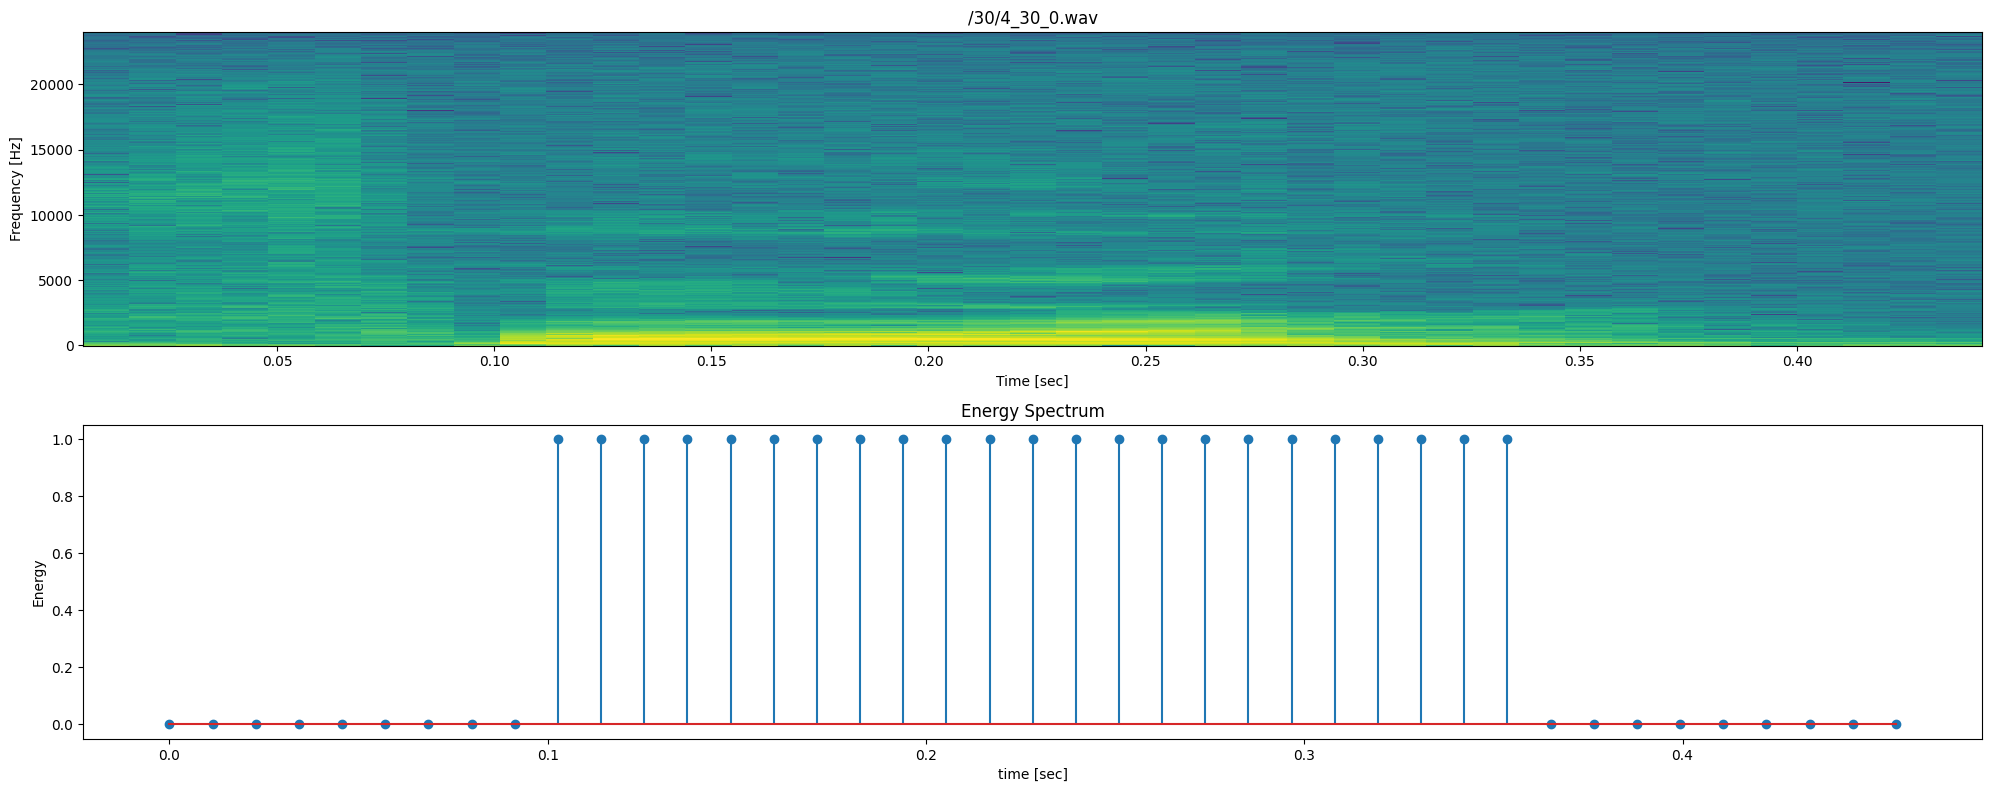

In [150]:
# song_file = '/01/0_01_0.wav'
song_file = '/30/4_30_0.wav'
Fs, data = read(curr_dir + song_file)
num_samples = len(data)
print("len of data: {}".format(num_samples))

noverlap = int(FRAME_SIZE / 2)
step = FRAME_SIZE - noverlap
numFrames = ceil(num_samples / step)
while ((numFrames - 1)*step + (FRAME_SIZE - 1) >= num_samples):
    numFrames -= 1

# numFrames = int(len(data) / FRAME_SIZE)
framesVoiced = np.zeros(numFrames)
t = np.linspace(0, len(data)/Fs, numFrames)

for i in range(numFrames):
    frame = data[i * step : (i + 1) * step]
    framesVoiced[i] = ece420ProcessFrame(frame.astype(float))

print("Sampling rate of: {}".format(Fs))

# conducting a STFT of the data with the same frame size to show a comparision of the visualized sound and its energy spectrum
f, t_stft, result = signal.stft(data, fs=Fs, window='hann', nperseg=FRAME_SIZE, nfft=FRAME_SIZE, noverlap=None, detrend=False, return_onesided=True, boundary=None, padded=False, axis=-1, scaling='psd')
result = 20*np.log10(np.abs(result))

print("Shape of STFT: {}".format(result.shape))
print("Number of Energy Spectrum Frames: {}".format(numFrames))
print("Len f: {}".format(len(f)))
print("Len t_stft: {}".format(len(t_stft)))

fig = plt.figure(figsize=(20,8))
plt.subplot(211)
plt.pcolormesh(t_stft, f, result)
plt.title(song_file)
plt.axis('tight')
plt.xlabel("Time [sec]")
plt.ylabel("Frequency [Hz]")
# plt.colorbar(format="%+2.f dB") # uncomment to interpret dB content, but leave out for side by side comparison 

plt.subplot(212)
plt.stem(t, framesVoiced)
plt.title("Energy Spectrum")
plt.xlabel("time [sec]")
plt.ylabel("Energy")

fig.tight_layout(pad=1.0)

In [151]:
# Recording of the sound
Audio(data, rate=Fs)

THRESHOLD is a tunable parameter that was set to 200e7 in lab but is instead 100e4 for the AudioMNIST dataset. Now that we have used our simple pitch detection to recognize which frames are voiced, we can attempt to do some trimming to get only the voiced segment.

9


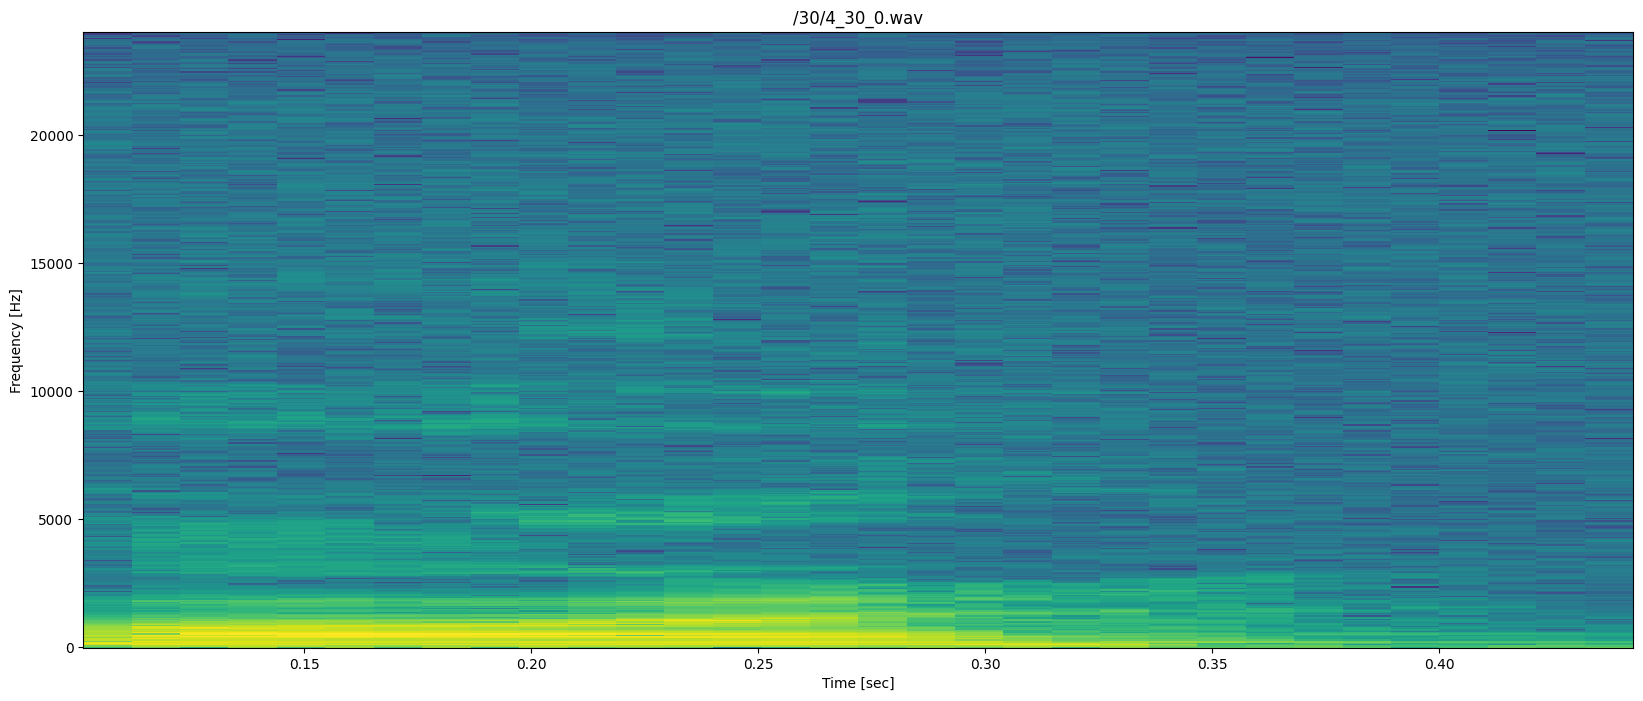

In [152]:
first_frame = np.argwhere(framesVoiced > 0)[0,0]
print(first_frame)
plt.figure(figsize=(20,8))
plt.pcolormesh(t_stft[first_frame:], f, result[:, first_frame:])
plt.title(song_file)
plt.axis('tight')
plt.xlabel("Time [sec]")
plt.ylabel("Frequency [Hz]")
Audio(data[first_frame*step:], rate=Fs)

Typically the most energy is found in words which employ a lower '-duh' frequency sound. This comes from letters such as D and B. Listening to the trimmed audio carefully, it is clear that the speaker pronounces the letter Z with a '-duh' sound which explains why that was the first frame where energy was detected. There is still some valuable data from the frames before as can be seen in the STFT spectrum so we will just constantly collect these few frames. 

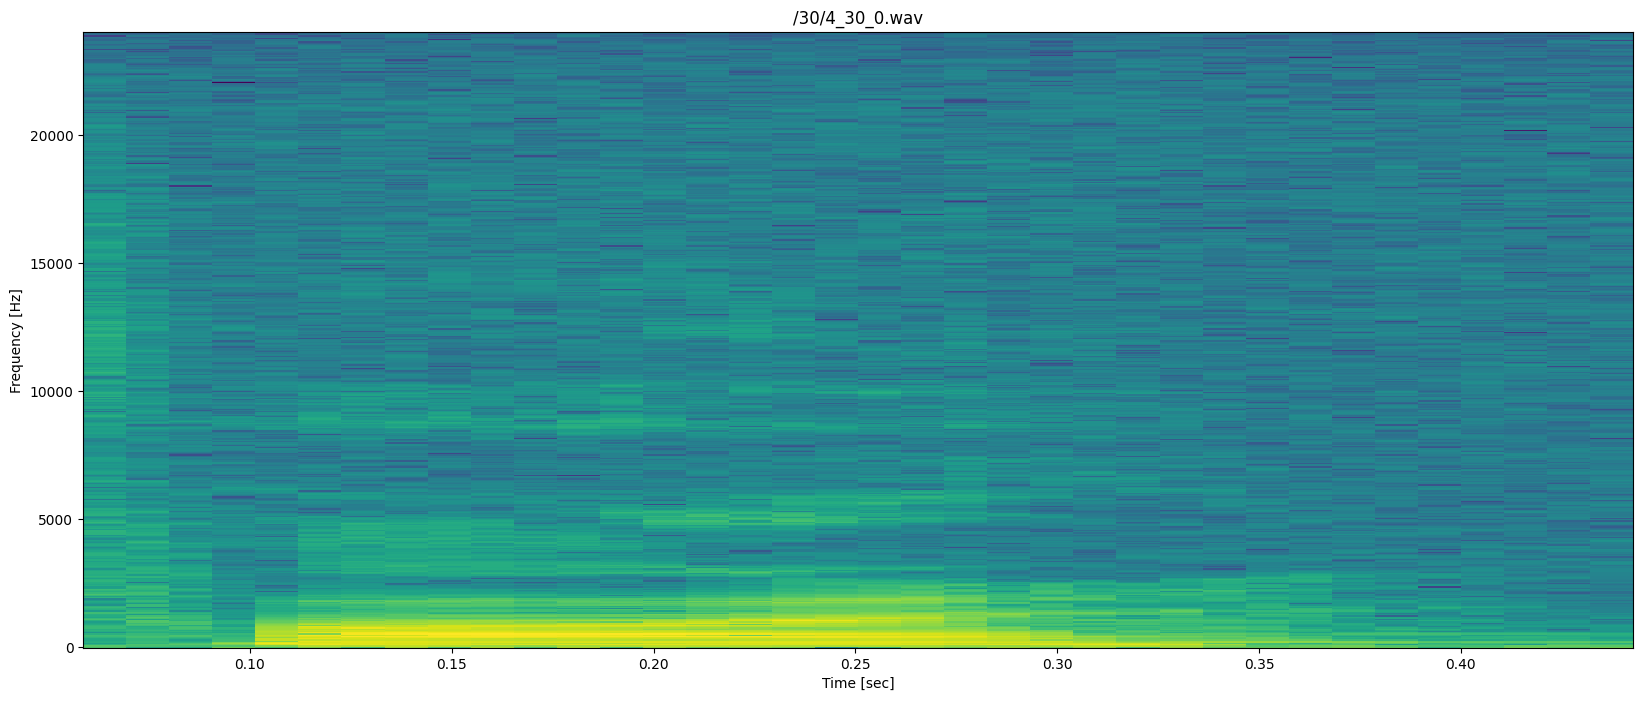

In [153]:
plt.figure(figsize=(20,8))
plt.pcolormesh(t_stft[first_frame-4:], f, result[:, first_frame-4:])
plt.title(song_file)
plt.axis('tight')
plt.xlabel("Time [sec]")
plt.ylabel("Frequency [Hz]")
Audio(data[(first_frame-4)*step:], rate=Fs)